In [4]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import model_from_json
import os, sklearn, pandas, numpy as np, random
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from sklearn.utils import shuffle
import imp
from sklearn.preprocessing import LabelBinarizer
# from pcanet import PCANet
from pcanet import PCANet
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [5]:
# set cwd back to default
os.chdir('../')
os.getcwd()

'/home/mark/src/dog-breed-identification/src'

In [6]:
# custom scripts
import config # params, constants
import data, models # functions that mutate outr data
# from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'validation' = ['img_name']
    , 'labels' = pandas.df('img_name','label')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


In [4]:
import data # src/data.py
dataset = data.init_dataset()

FileNotFoundError: File b'../datasets/labels.csv' does not exist

In [ ]:
import os
os.listdir('../models')

### load a model

In [92]:
# load json and create model
# load json and create model
def load_model(filename, weights):
    with open(filename, 'r') as json: # cnn_transfer_augm
        loaded_model_json = json.read()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights)
    print("Loaded model from disk")
    optimizer = optimizers.Adam(lr=0.001)
    loaded_model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy',
        'mean_squared_error','categorical_crossentropy','top_k_categorical_accuracy'])
    print('compiled model')
    return loaded_model

In [93]:
model_augment = config.dataset_dir + 'models/cnntransfer_augm.json'
model_augment_weights = config.dataset_dir + 'models/cnntransferweights_augmen.h5'
model_default = config.dataset_dir + 'models/cnntransfer.json'
model_default_weights = config.dataset_dir + 'models/cnntransferweights.h5'

# augment = load_model(model_augment, model_augment_weights)
default = load_model(model_default, model_default_weights)
augment = load_model(model_augment, model_augment_weights)

Loaded model from disk
compiled model
Loaded model from disk
compiled model


In [82]:
# pick the n classes with the most occuring instances
amt = 5
classes = data.top_classes(dataset.labels, amt)
classes

['paper', 'glass', 'plastic', 'metal', 'cardboard']

In [83]:
maxx = 100
max_train = 100
x_test, n = data.extract_topx_classes(dataset, classes, 'test', maxx, max_train)
n

100

In [84]:
x_test, y_test, n = data.extract_all_test(dataset, x_test)

extract all data: 500


In [85]:
# y_train, y_test, y_validation = data.labels_to_vectors(dataset, y_train, y_test, y_validation)
y_test = data.one_hot(y_test)
input_shape = y_test.shape[1:] # = shape of an individual image (matrix)
output_length = (y_test[0]).shape[0] # = length of an individual label
output_length

5

## running tests


In [89]:
# import sklearn.metrics.confusion_matrix

def evaluate(model):
    cvscores = []
    scores = model.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# evaluate(model_final_augmentation)

In [97]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

def test1(model, x_test, y_test):
    y_pred_class = model.predict(x_test)
    # con = tf.confusion_matrix(labels=y_test, predictions=y_pred_class )
    # print(con)

    y_test_non_category = [ np.argmax(t) for t in y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y_pred_class ]


    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    print(conf_mat)
    return conf_mat

In [100]:
c1 = test1(default, x_test, y_test)

[[60  3  1 25 11]
 [ 0 85  2  0 13]
 [ 0  8 76  0 16]
 [ 0  2  0 96  2]
 [ 0  3  0  2 95]]


In [103]:
c2 = test1(augment, x_test, y_test)

[[ 3  2  5 85  5]
 [ 0 76 19  2  3]
 [ 0 13 72  9  6]
 [ 0  0  2 95  3]
 [ 0 36 22  5 37]]


In [9]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# comparable but different from: mlxtend.plotting.plot_confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
labels = np.array(['Glass','Paper','Cardboard','Plastic','Metal'])
labels = np.array(['Paper', 'Glass', 'Plastic', 'Metal', 'Cardboard'])

In [11]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [
    'Times New Roman', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana'
]
rcParams['font.size'] = 15

In [5]:
labels

NameError: name 'classes' is not defined

In [ ]:
c_ = c1

In [8]:
c1 = np.array([[29,  1,  1, 24,  5],
 [ 0, 41,  2,  1, 16],
 [ 0, 11, 34,  1, 14],
 [ 0,  0,  0, 55,  5],
 [ 0,  5,  0,  4, 51]])

Confusion matrix, without normalization
[[29  1  1 24  5]
 [ 0 41  2  1 16]
 [ 0 11 34  1 14]
 [ 0  0  0 55  5]
 [ 0  5  0  4 51]]


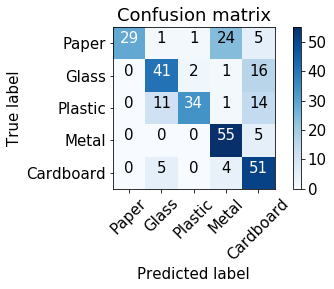

In [14]:
# from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(c1, labels)

In [7]:
c2 = np.array([[ 3,  2,  5, 85,  5],
 [ 0, 76, 19,  2,  3,],
 [ 0, 13, 72,  9,  6,],
 [ 0,  0,  2, 95,  3,],
 [ 0, 36, 22,  5, 37]])

Confusion matrix, without normalization
[[ 3  2  5 85  5]
 [ 0 76 19  2  3]
 [ 0 13 72  9  6]
 [ 0  0  2 95  3]
 [ 0 36 22  5 37]]


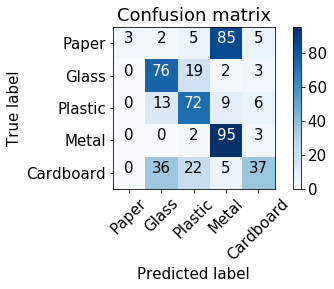

In [21]:
# from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(c2, labels)

## T-tests
ttest for the TP per class, between the 2 networks

In [9]:
tp_c1 = c1.diagonal()
tp_c2 = c2.diagonal()
print(tp_c1)
print(tp_c2)

[29 41 34 55 51]
[ 3 76 72 95 37]


In [10]:
from utils import utils

In [11]:
utils.ttest(0.05, tp_c1, tp_c2)

RESULT - NO significant difference found


(False, -0.8551914997243899, 0.417319745600954)

In [13]:
utils.ttest(0.05, tp_c1.flatten(), tp_c2.flatten())

RESULT - NO significant difference found


(False, -0.8551914997243899, 0.417319745600954)

In [36]:
def select_not_diagonal(arr=[]):
    a = arr.copy()
    np.fill_diagonal(a, -1)
    return [x for x in list(a.flatten()) if x > -1]

In [38]:
# everything nog at the diagonal axes is either fp or fn
#  with fn or fp depending on the perspective (which class == p)
c1_ = select_not_diagonal(c1)
c2_ = select_not_diagonal(c2)
print(c1_)
print(c2_)

[1, 1, 24, 5, 0, 2, 1, 16, 0, 11, 1, 14, 0, 0, 0, 5, 0, 5, 0, 4]
[2, 5, 85, 5, 0, 19, 2, 3, 0, 13, 9, 6, 0, 0, 2, 3, 0, 36, 22, 5]


In [41]:
utils.ttest(0.05, c1_, c2_)

RESULT - NO significant difference found


(False, -1.3631878569954565, 0.18084635295062876)

In [80]:
def recall_precision(cm=[[]]):
    print('label, recall, precision')
    total = sum(cm.flatten())
    for i, label in enumerate(labels):
        # e.g. label = paper
        true_paper = cm[i]
        tp = cm[i][i] # upper left corner
        fp = sum(cm[i]) - tp # upper col minus tp
        # vertical col
        col = [row[i] for row in cm ]
        fn = sum(col) - tp
        tn = total - tp - fp - fn
        print(label, ':', round(tp * 1./ (tp + fn),3), round(tp * 1./ (tp + fp),3))
#         print(round(tp * 1./ (tp + fp),3))


print('c1 - no aug')        
recall_precision(c1)
print('c2 - aug')        
recall_precision(c2)

c1 - no aug
label, recall, precision
Paper : 1.0 0.483
Glass : 0.707 0.683
Plastic : 0.919 0.567
Metal : 0.647 0.917
Cardboard : 0.56 0.85
c2 - aug
label, recall, precision
Paper : 1.0 0.03
Glass : 0.598 0.76
Plastic : 0.6 0.72
Metal : 0.485 0.95
Cardboard : 0.685 0.37
